In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Dropout, Dense, GRU, Embedding, LSTM, Bidirectional, TimeDistributed, Flatten
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
def loadData_Tokenizer(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0).astype("str")
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open(r"C:\Users\Tejas\Desktop\Capstone\hate-speech-project\glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)

In [46]:
def Build_Model_RNN_Text(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    """
    def buildModel_RNN(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    word_index in word index ,
    embeddings_index is embeddings index, look at data_helper.py
    nClasses is number of classes,
    MAX_SEQUENCE_LENGTH is maximum lenght of text sequences
    """
    model = Sequential()
    hidden_layer = 3
    lstm_node = 32
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    print(lstm_node)
    for i in range(0,hidden_layer):
        model.add(Bidirectional(LSTM(lstm_node,return_sequences=True, recurrent_dropout=0.2)))
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))
    model.add(Dropout(dropout))
    #model.add(TimeDistributed(Dense(256)))
    #model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [47]:
def experiment(train_df, test_df):
  print("Running Experiment ... ")
  X_train = train_df.Text
  y_train = train_df.label.astype(np.float32)

  X_test = test_df.Text
  y_test = test_df.label.astype(np.float32)
  # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
  print("Generating Glove ...")
  X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test)
  with warnings.catch_warnings():
    print("Building Model ...")
    model_RNN = Build_Model_RNN_Text(word_index,embeddings_index, 2)
    model_RNN.summary()
    print("\n Starting Training ... \n")
    history = model_RNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=7,
                              batch_size=128,
                              verbose=1)
    warnings.simplefilter("ignore")
  print("\n Plotting results ... \n")
  plot_graphs(history, 'accuracy')
  plot_graphs(history, 'loss')
  print("\n Evaluating Model ... \n")
  predicted = model_RNN.predict(X_test_Glove)
  #print(predicted)
  print("YTEST")
  print(y_test[-20:-10])
  print("PREDICTED")
  
  print(predicted[-20:-10])
  binary_predictions = []

  for val in predicted:
    if val[0] >= 0.5:
      binary_predictions.append(0.0)
    elif val[0] < 0.5:
      binary_predictions.append(1.0)

  print(metrics.classification_report(y_test, binary_predictions))
  print("\n")
  logger = logging.getLogger("logger")
  result = compute_metrics(y_test, binary_predictions)
  for key in (result.keys()):
      logger.info("  %s = %s", key, str(result[key]))

In [37]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def class_balance(df, target):
  cls = df[target].value_counts()
  cls.plot(kind='bar')
  plt.show()

In [39]:
train = pd.read_csv(r'C:\Users\Tejas\Desktop\Capstone\DatasetsCleaned\UniformClasses\Clean\davidson2017train.csv')

In [9]:
train['label'] = ''

for row in range(len(train)):
    if train['Class'][row] == "OFF":
        train['label'][row] = 1
    else:
        train['label'][row] = 0

In [40]:
test = pd.read_csv(r'C:\Users\Tejas\Desktop\Capstone\DatasetsCleaned\UniformClasses\Clean\davidson2017test.csv')

In [11]:
test['label'] = ''

for row in range(len(test)):
    if test['Class'][row] == "OFF":
        test['label'][row] = 1
    else:
        test['label'][row] = 0

In [12]:
train_df = shuffle(train)
test_df = shuffle(test)

Running Experiment ... 
Generating Glove ...
Found 37443 unique tokens.
(31788, 500)
Total 400000 word vectors.
Building Model ...
32
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 500, 50)           1872200   
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 500, 64)           21248     
_________________________________________________________________
dropout_24 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 500, 64)           24832     
_________________________________________________________________
dropout_25 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 500, 64)       

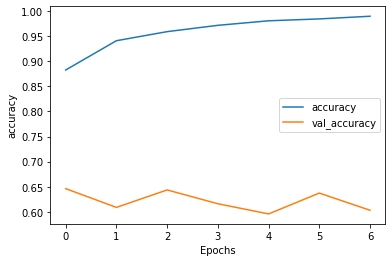

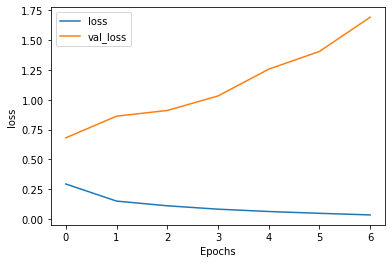


 Evaluating Model ... 



INFO:logger:  mcc = 0.16293410980342846
INFO:logger:  tp = 1300
INFO:logger:  tn = 2924
INFO:logger:  fp = 1532
INFO:logger:  fn = 1249
INFO:logger:  precision = 0.4590395480225989
INFO:logger:  recall = 0.5100039231071009
INFO:logger:  F1 = 0.4831815647649136
INFO:logger:  accuracy = 0.6029978586723769


YTEST
2415    0.0
5840    1.0
3773    0.0
5584    1.0
3315    0.0
1679    0.0
781     0.0
6783    1.0
2304    0.0
391     1.0
Name: label, dtype: float32
PREDICTED
[[0.06931783 0.9306822 ]
 [0.9973941  0.00260591]
 [0.01603732 0.9839627 ]
 [0.00402404 0.99597603]
 [0.9772017  0.02279834]
 [0.99346316 0.00653682]
 [0.9827016  0.01729838]
 [0.9786952  0.02130485]
 [0.12840986 0.87159014]
 [0.02147465 0.97852534]]
              precision    recall  f1-score   support

         0.0       0.70      0.66      0.68      4456
         1.0       0.46      0.51      0.48      2549

    accuracy                           0.60      7005
   macro avg       0.58      0.58      0.58      7005
weighted avg       0.61      0.60      0.61      7005





In [48]:
experiment(train_df, test_df)